# Problem 1 - MCAR: Customer Demographics

## Context
This dataset simulates customer demographic information. One variable (`Age`) has missing values.

**Goal:**
1. Diagnose the missingness type (MCAR/MAR/MNAR).
2. Select and justify a hoandling strategy.
3. Evaluate impact on analysis/modeling.
4. Summarize recommended playbook.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv(r'C:\Users\theha\OneDrive\Desktop\Projects\Mini_Project_Missing_Values\problem1_mcar_customer_demographics.csv')

# Peek data
df.head()

,CustomerID,Age,Gender,Income,City
0,1,41.0,Male,66575,Toronto
1,2,35.0,Female,12272,Vancouver
2,3,42.0,Female,72231,Toronto
3,4,51.0,Female,28904,Sydney
4,5,34.0,Female,49563,Toronto


## Step 1: Data Overview

We start by checking:
- Shape of dataset
- Data types
- Missing values summary
- Basic statistics

In [2]:
from IPython.display import display

# Shape
display(df.shape)

# Info
df.info()

# Missing summary
display(df.isnull().sum())

# Percentage
display((df.isnull().mean() * 100).round(2))

# Quick statistics
df.describe(include="all")

(600, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  600 non-null    int64  
 1   Age         539 non-null    float64
 2   Gender      600 non-null    object 
 3   Income      600 non-null    int64  
 4   City        600 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 23.6+ KB


CustomerID     0
Age           61
Gender         0
Income         0
City           0
dtype: int64

CustomerID     0.00
Age           10.17
Gender         0.00
Income         0.00
City           0.00
dtype: float64

,CustomerID,Age,Gender,Income,City
count,600.000000,539.000000,600,600.000000,600
unique,NaN,NaN,3,NaN,5
top,NaN,NaN,Female,NaN,Sydney
freq,NaN,NaN,295,NaN,130
mean,300.500000,35.742115,NaN,56031.271667,NaN
std,173.349358,9.663978,NaN,15344.597677,NaN
min,1.000000,4.000000,NaN,11180.000000,NaN
25%,150.750000,29.000000,NaN,45347.000000,NaN
50%,300.500000,36.000000,NaN,55852.500000,NaN
75%,450.250000,42.000000,NaN,66030.500000,NaN


## Step 2: Missingness Exploration

We check if `Age` missingness is random or depends on other variables.

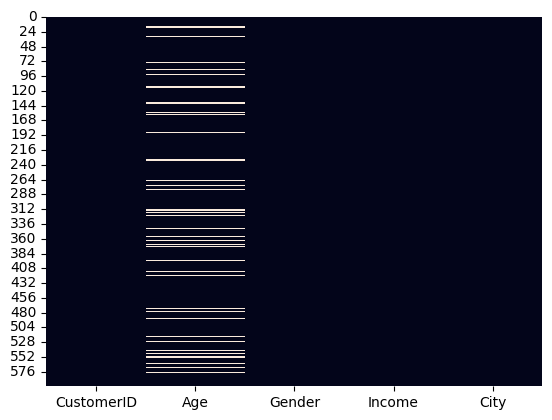

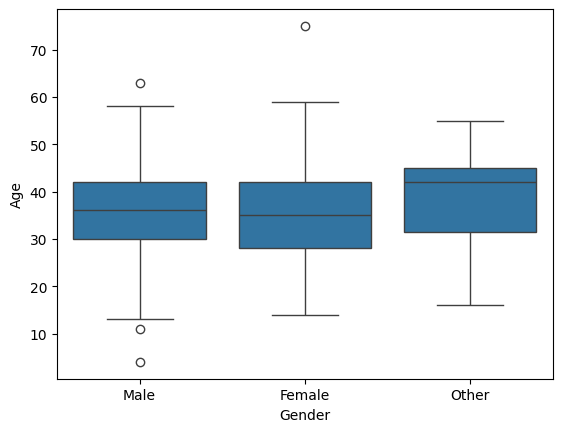

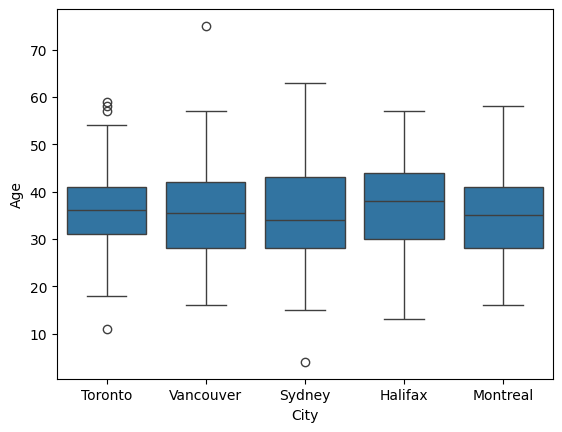

In [3]:
# Heatmap of missing values
sns.heatmap(df.isnull(), cbar=False)
plt.show()

# Compare Age distribution by Gender
sns.boxplot(x="Gender", y="Age", data=df)
plt.show()

# Compare Age distribution by City
sns.boxplot(x="City", y="Age", data=df)
plt.show()

## Step 3: Handling Strategies

We will try 3 approaches for handling the missing values in `Age`:

1. **Drop rows with missing `Age`**  
    -> Simple, but loses ~10% of data

2. **Median Imputation**  
    -> Keeps all rows, robust to skewed distribution.

3. **KNN Imputation**  
    -> Uses other features (`Gender`, `Income`, `City`) to predict missing **Age**.

In [4]:
from sklearn.impute import KNNImputer

# 1. Drop rows with missing Age
df_drop = df.dropna(subset=['Age']).copy()

# 2. Median Imputation
df_median = df.copy()
median_age = df['Age'].median()
df_median['Age'] = df_median['Age'].fillna(median_age)

# 3. KNN Imputation
df_knn = df.copy()
# just keeps numeric col to KNN active (Age, Income)
# Then could encdode more Gender/ City if would like to upgrade
knn_imputer = KNNImputer(n_neighbors=5)
df_knn[['Age','Income']] = knn_imputer.fit_transform(df_knn[['Age', 'Income']])

In [5]:
print("Original missing:\n", df.isnull().sum())
print("\nAfter Drop:\n", df_drop.isnull().sum())
print("\nAfter Median:\n", df_median.isnull().sum())
print("\nAfter KNN:\n", df_knn.isnull().sum())

Original missing:
 CustomerID     0
Age           61
Gender         0
Income         0
City           0
dtype: int64

After Drop:
 CustomerID    0
Age           0
Gender        0
Income        0
City          0
dtype: int64

After Median:
 CustomerID    0
Age           0
Gender        0
Income        0
City          0
dtype: int64

After KNN:
 CustomerID    0
Age           0
Gender        0
Income        0
City          0
dtype: int64


## Step 4: Evaluate the Impact

We compare the distributions of `Age` under 3 handling strategies:
1. Drop rows
2. Median Imputation
3. KNN Imputation

We check:
- Histogram & boxplot of Age
- Summary statistics (mean, median, std)
- (Optional) Impact on a simple model, e.g. predicting Income ~ Age

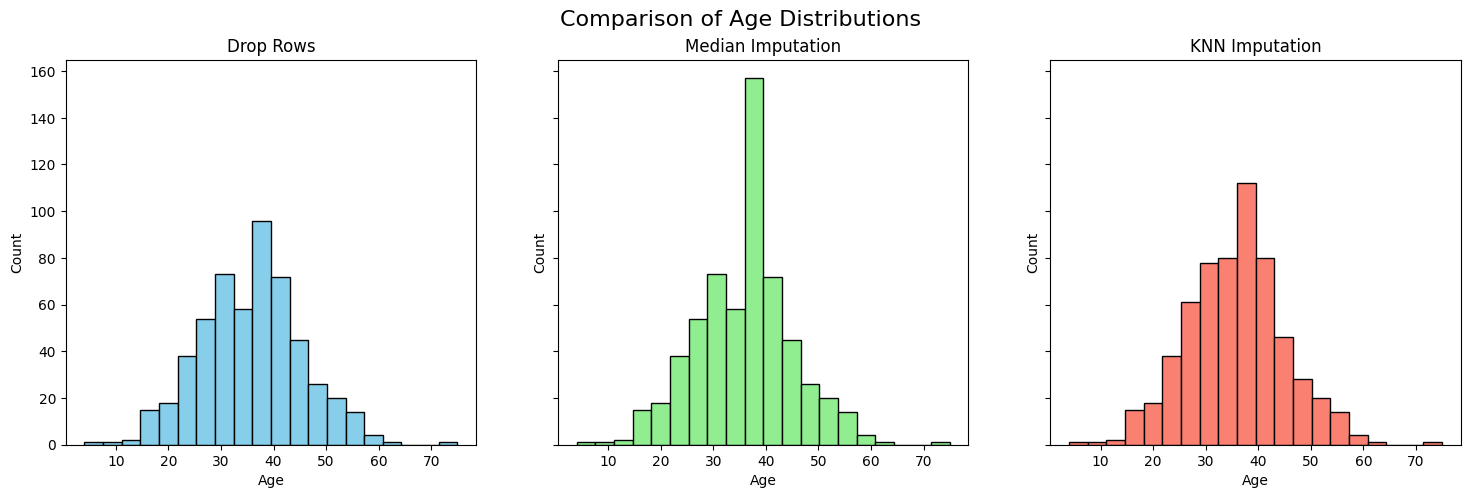

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)

# Drop
axes[0].hist(df_drop['Age'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title("Drop Rows")

# Median
axes[1].hist(df_median['Age'], bins=20, color='lightgreen', edgecolor='black')
axes[1].set_title("Median Imputation")

# KNN
axes[2].hist(df_knn['Age'], bins=20, color='salmon', edgecolor='black')
axes[2].set_title("KNN Imputation")

for ax in axes:
    ax.set_xlabel("Age")
    ax.set_ylabel("Count")

plt.suptitle("Comparison of Age Distributions", fontsize=16)
plt.show()

### Step 4: Evaluation – Insights

- **Drop Rows:** Preserves the natural distribution of `Age`, but reduces sample size (600 → 539).  
- **Median Imputation:** Keeps all rows, but creates an artificial “spike” at the median → distorts the distribution.  
- **KNN Imputation:** Retains all data and reconstructs a more natural distribution by leveraging other features.

### Conclusion:  
- With large datasets, **Drop Rows** is acceptable.  
- To preserve all data, **KNN Imputation** is more realistic than Median.  
- **Median** is suitable as a quick and simple fix.

In [7]:
summary = pd.DataFrame({
    "Original": df['Age'].describe(),
    "Drop": df_drop['Age'].describe(),
    "Median": df_median['Age'].describe(),
    "KNN": df_knn['Age'].describe()
})
summary

,Original,Drop,Median,KNN
count,539.000000,539.000000,600.000000,600.000000
mean,35.742115,35.742115,35.768333,35.707667
std,9.663978,9.663978,9.159029,9.279281
min,4.000000,4.000000,4.000000,4.000000
25%,29.000000,29.000000,30.000000,29.000000
50%,36.000000,36.000000,36.000000,36.000000
75%,42.000000,42.000000,41.000000,42.000000
max,75.000000,75.000000,75.000000,75.000000


### Summary Statistics – Insights

- **Drop Rows:** Distribution remains unchanged, but dataset shrinks (539 rows).  
- **Median Imputation:** Preserves sample size but reduces variance (std ↓) and creates concentration at the median.  
- **KNN Imputation:** Preserves sample size and closely matches the original distribution’s mean, median, and spread.  

### Conclusion:  
KNN is the best balance between preserving data and maintaining statistical properties, while Drop is acceptable if data loss is not an issue. Median should be considered only for quick fixes.

# Playbook Summary – MCAR (~10% missing)

- **Diagnosis:** Missingness in `Age` appears random (no clear relation to Gender/City/Income). Little’s Test could confirm MCAR.
- **Handling options:**
  - **Drop Rows:** Safe if dataset is large; no distribution distortion but data loss.
  - **Median Imputation:** Quick fix, keeps sample size, but reduces variance and creates artificial spike.
  - **KNN Imputation:** Keeps all rows, preserves distribution more naturally by using correlated features.
- **Recommendation:** 
  - If dataset is small → prefer **imputation**.  
  - For realistic modeling → **KNN Imputation** is preferred.  
  - For fast/simple solution → **Median Imputation** is acceptable.